In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/논문/DCN/Results

/content/drive/MyDrive/논문/DCN/Results


In [5]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 51kB 3.0MB/s 
     |████████████████████████████████| 3.7MB 5.9MB/s 


In [6]:
import os
import sys
import gc
import glob
import joblib
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import tensorflow as tf
import tensorflow_recommenders as tfrs

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, Callback
from tensorflow.keras.utils import plot_model

# 0. Data Load

In [32]:
train = pd.read_json(os.path.join('..', 'Data', 'train.json'))
test = pd.read_json(os.path.join('..', 'Data', 'test.json'))

In [20]:
train

,user_note,rating_per_user,vintage_id,user_like_count,userID,wine_id,wine_name,url,like
0,,4.0,142514980,0,19484511,2532733,Secateurs Red Blendn2016,/badenhorst-family-wines-secateurs-red-blend-s...,1
1,,3.5,48346487,0,19484511,1253802,Kloof Street Swartland Rougen2015,/mullineux-kloof-street-swartland-rouge/w/1253...,0
2,Beautiful golden nectar,3.5,156865950,1,19484511,1123441,Late Harvestn2018,/stables-late-harvest/w/1123441?year=2018,0
3,,3.5,150284640,0,19484511,1157656,Proseccon2017,/ruffino-prosecco/w/1157656?year=2017,0
4,Bright clean and refreshing,3.5,1471106,0,19484511,1134756,Prosecco TrevisonN.V.,/la-gioiosa-prosecco-treviso/w/1134756?year=N.V.,0
...,...,...,...,...,...,...,...,...,...
937751,Pas mal,3.5,14525114,0,16607503,1135203,Sauvignon Blanc (Reserva)n2015,/casillero-del-diablo-sauvignon-blanc-reserva-...,0
937752,Dry. Might do better with food.,3.0,137807000,0,16607503,4303173,Cabernet Sauvignonn2013,/chateau-st-jean-cabernet-sauvignon-california...,0
937753,,4.0,5576831,0,16607503,2364090,Syrahn2013,/fat-bastard-syrah/w/2364090?year=2013,1
937754,Pas mal,3.5,16730794,0,16607503,1679387,Sauvignon Blancn2015,/starborough-sauvignon-blanc/w/1679387?year=2015,0


In [10]:
item = pd.read_csv(os.path.join('..', 'Data', 'item.csv'))
item

,wine_id,name,rating_count,rating_average,label_count,review_count,body,alcohol,winery_ratings_count,winery_ratings_average,winery_labels_count,winery_wines_count,Aperitif,Appetizers and snacks,Blue cheese,Cured Meat,Fruity desserts,Game,Goat cheese,Lamb,Lean fish,Mature and hard cheese,Mild and soft cheese,Mushrooms,Pasta,Pork,Poultry,Rich fish,Shellfish,Spicy food,Sweet desserts,Veal,Vegetarian,Beef,Blue cheese.1,Fruity desserts.1,Game .1,Lamb.1,Mature and hard cheese.1,Pasta.1,...,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,grapes_id,region_id,country_code,type_id,winery_id,segment
0,1938520,1882 Cabernet Sauvignon,1697,4.1,14879,16,5.0,14.5,18888.0,4.3,121618.0,62.0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,-1.551669,4.234245,-4.399549,-1.394831,4.230004,2.214657,3.698479,-11.544035,3.926973,2.027013,-3.108813,0.066079,3.901737,5.336387,-2.893791,-7.887779,-12.434086,5.029867,-2.870348,1.098466,0.041303,-0.516198,0.322788,-0.443685,-3.136951,0.742006,0.173241,-1.924884,-1.610956,2.868221,-2.167123,1.151749,1.444787,2.489641,[2],105.0,us,1,2412.0,2
1,14604,Les Bessards Hermitage,1078,4.3,5370,3,5.0,14.0,72079.0,3.8,462021.0,57.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,3.201073,3.788378,1.210495,1.083187,0.590964,3.617076,0.106284,7.155894,1.924063,-1.217552,3.798950,-0.573204,0.910653,2.294474,-1.256222,-1.491831,-2.579453,-0.628009,-0.097134,-4.154698,-2.861205,-4.497887,1.583489,-0.026252,-1.082327,0.338037,-2.199833,-0.638129,1.981586,1.148229,-0.780446,-1.026985,-3.631833,-0.124608,[1],535.0,fr,1,7636.0,2
2,1930757,Patriarch Estate Grown,1072,4.6,6042,25,4.0,14.2,7747.0,4.4,49362.0,21.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,...,1.994470,3.356056,-0.923651,0.741282,2.596084,7.155602,-1.910814,-3.998637,-0.054258,0.587277,-0.887633,-0.478954,-0.442926,-1.749812,-1.185678,-0.141588,0.728802,-1.242658,0.493817,-1.872077,-2.067729,-3.043356,0.165190,0.615640,-0.657080,0.566004,0.658332,-0.343338,-1.285816,0.543290,-0.569400,1.647680,-1.445715,-0.359417,"[2, 10]",88.0,us,1,1905.0,2
3,1564280,Merlot,3577,4.3,18748,52,4.0,14.4,14091.0,4.4,83324.0,19.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,...,-6.055126,-6.163670,-17.412258,3.399827,0.748214,17.899010,-2.046424,-11.186761,12.007775,0.894301,5.050331,-2.478301,8.826864,7.167604,-6.359656,-1.473321,-3.462038,4.614712,-0.875028,-7.256990,-2.221329,-6.283630,-0.477432,0.779232,2.592272,-0.271975,1.884531,0.176404,4.579372,1.793655,-4.051642,3.926317,-2.261881,-0.431446,[10],24.0,us,1,1297.0,2
4,2576427,Cabernet Sauvignon F Block,115,4.4,806,1,5.0,0.0,1077.0,4.4,7749.0,18.0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0.004828,-0.478264,-1.010209,-0.003157,0.367176,-0.270334,-0.550214,0.490301,-0.315579,0.299809,-0.471115,-0.199453,-0.326484,-0.776345,-0.717146,0.147173,0.347295,-0.071307,0.385532,-0.230784,0.216109,0.222512,-0.104980,-0.133218,-0.016644,-0.063100,-0.098678,0.082621,0.164888,-0.078193,0.113466,0.270745,0.158934,-0.330067,[2],42.0,us,1,2232.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50855,1669561,Garganega - Pinot Grigio,788,3.5,6635,9,3.0,0.0,64503.0,3.4,675950.0,517.0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,...,-2.485011,2.759754,4.344064,5.879612,6.098274,-4.947739,-16.347866,-1.587228,-0.347483,0.651422,-1.428200,-8.428909,7.573254,-1.850378,3.491681,-3.918680,2.280340,-2.029659,-0.074605,-1.342461,7.684682,-1.910718,2.096102,-1.339733,0.081186,0.734952,-0.616824,0.442448,-0.520157,2.901

# 1. Data Preprocess

In [17]:
str_features = ["userID", "country_code", 'wine_id', 'grapes_id']
int_features = ["type_id", "body", "acidity_y", 'user_like_count', 'rating_count', 'alcohol']
label_feature=["like"]
feature_names = str_features + int_features + label_feature

In [33]:
# 해당 wine_id는 같은 wine을 의미하지만 wine정보는 1183966만 있는 것으로 보임
train.loc[train['wine_id'] == 1886805, 'wine_id'] = 1183966
test.loc[test['wine_id'] == 1886805, 'wine_id'] = 1183966

In [34]:
train = train.merge(item, on = 'wine_id', how = 'left')
test = test.merge(item, on = 'wine_id', how = 'left')

In [35]:
add_train = train[feature_names]
add_test = test[feature_names]

add_train

,userID,country_code,wine_id,grapes_id,type_id,body,acidity_y,user_like_count,rating_count,alcohol,like
0,19484511,za,2532733,"[1, 2, 8, 22, 62, 75]",1,4.775585,3.299066,0,3737,13.2,1
1,19484511,za,1253802,"[41, 1, 8, 22]",1,5.218711,2.762091,0,3024,13.5,0
2,19484511,nz,1123441,[15],7,3.341643,6.068770,1,129,13.5,0
3,19484511,it,1157656,[1697],3,1.000000,3.897176,0,9470,11.0,0
4,19484511,it,1134756,[112],3,1.000000,3.789180,0,9759,11.0,0
...,...,...,...,...,...,...,...,...,...,...,...
937751,16607503,cl,1135203,[17],2,3.000000,4.007651,0,21221,13.0,0
937752,16607503,us,4303173,[2],1,4.000000,3.046538,0,6636,0.0,0
937753,16607503,fr,2364090,[1],1,4.000000,3.937701,0,5006,0.0,1
937754,16607503,nz,1679387,[17],2,2.000000,4.501861,0,13707,0.0,0


In [36]:
sys.path.append(os.path.join('..', 'Preprocess'))
sys.path.append(os.path.join('..', 'Models'))
import preprocess
import DCN

import imp
imp.reload(preprocess)

<module 'preprocess' from '../Preprocess/preprocess.py'>

In [ ]:
cached_train, vocabularies = preprocess.DCN(add_train, str_features, int_features, df_type='train')
cached_test = preprocess.DCN(add_test, str_features, int_features, df_type = 'test')

In [38]:
vocabularies

{'acidity_y': array([ 0,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 74, 75]),
 'alcohol': array([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  23,  45,  80, 112, 114,
        135]),
 'body': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'country_code': array([b'al', b'am', b'ar', b'at', b'au', b'be', b'bg', b'bo', b'br',
        b'ca', b'ch', b'cl', b'cn', b'cy', b'cz', b'de', b'dk', b'es',
        b'fr', b'gb', b'ge', b'gr', b'hr', b'hu', b'il', b'in', b'it',
        b'jp', b'lb', b'lu', b'ma', b'md', b'me', b'mk', b'mt', b'mx',
        b'nl', b'nz', b'pe', b'ps', b'pt', b'ro', b'rs', b'ru', b'se',
        b'si', b'sk', b'th', b'tn', b'tr', b'ua', b'unk', b'us', b'uy',
        b'za'], dtype=object),
 'gra

# 2. Model

In [39]:
learning_rate = 0.001
model = DCN.model(str_features = str_features,
                        int_features = int_features,
                        cross_layer_sizes = 1,
                        learning_rate=learning_rate,
                        vocabularies=vocabularies,
                        deep_layer_sizes=[192, 192], projection_dim=None)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))

# 3. Train

In [40]:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'binary_accuracy',
    patience = 20)

In [41]:
history= model.fit(cached_train,  epochs=500, verbose=True, callbacks=[callback])

Epoch 1/500
115/115 [==============================] - 17s 118ms/step - binary_accuracy: 0.6496 - loss: 0.6193 - regularization_loss: 0.0000e+00 - total_loss: 0.6193
Epoch 2/500
115/115 [==============================] - 4s 37ms/step - binary_accuracy: 0.7277 - loss: 0.5375 - regularization_loss: 0.0000e+00 - total_loss: 0.5375
Epoch 3/500
115/115 [==============================] - 4s 38ms/step - binary_accuracy: 0.7504 - loss: 0.5038 - regularization_loss: 0.0000e+00 - total_loss: 0.5038
Epoch 4/500
115/115 [==============================] - 4s 38ms/step - binary_accuracy: 0.7645 - loss: 0.4791 - regularization_loss: 0.0000e+00 - total_loss: 0.4791
Epoch 5/500
115/115 [==============================] - 4s 38ms/step - binary_accuracy: 0.7700 - loss: 0.4671 - regularization_loss: 0.0000e+00 - total_loss: 0.4671
Epoch 6/500
115/115 [==============================] - 4s 38ms/step - binary_accuracy: 0.7805 - loss: 0.4488 - regularization_loss: 0.0000e+00 - total_loss: 0.4488
Epoch 7/500
11

# 4. Result

In [ ]:
DCN.getResult(model, cached_test, metric = 'binary')

ROC: 0.9565316452775086
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     81030
           1       0.92      0.94      0.93     93416

    accuracy                           0.93    174446
   macro avg       0.93      0.92      0.92    174446
weighted avg       0.93      0.93      0.93    174446



In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 64)                256       
_________________________________________________________________
sequential_9 (Sequential)    (None, 64)                1600      
_________________________________________________________________
sequential_5 (Sequential)    (None, 64)                384       
_________________________________________________________________
sequential_1 (Sequential)    (None, 64)                1664      
_________________________________________________________________
sequential_3 (Sequential)    (None, 64)                25536     
_________________________________________________________________
sequential_8 (Sequential)    (None, 64)                495296    
_________________________________________________________________
sequential_4 (Sequential)    (None, 64)                448   

In [ ]:
import seaborn as sns
plt.style.use('seaborn') # seaborn 스타일로 변환
sns.set(rc={'figure.figsize' : (15,15)})

<Figure size 1800x1800 with 0 Axes>

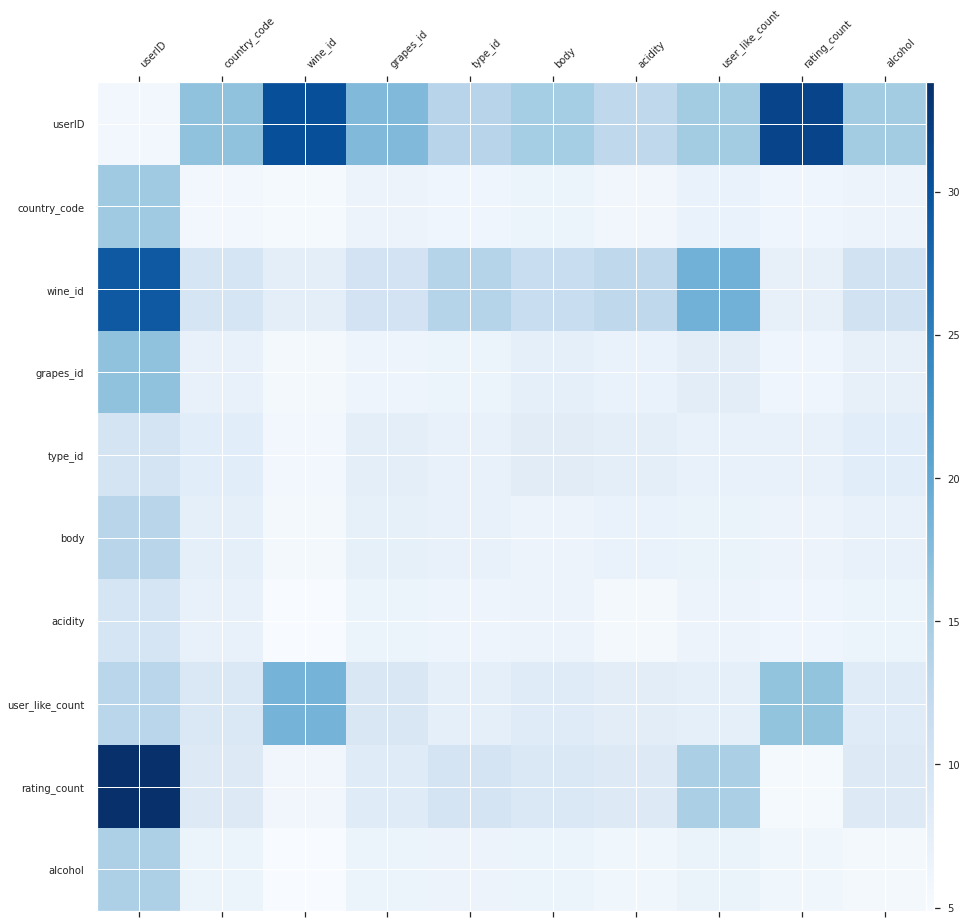

In [ ]:
# Cross layer 1 weights
try:
    mat = model._cross_layer[0]._dense.kernel
    features = model._all_features
    block_norm = np.ones([len(features), len(features)])

    dim = model.embedding_dimension

    # Compute the norms of the blocks.
    for i in range(len(features)):
        for j in range(len(features)):
            block = mat[i * dim:(i + 1) * dim,
                        j * dim:(j + 1) * dim]
            block_norm[i,j] = np.linalg.norm(block, ord="fro")

    plt.figure(figsize=(25,25))
    im = plt.matshow(block_norm, cmap=plt.cm.Blues)
    ax = plt.gca()
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="1%", pad=0.001)
    plt.colorbar(im, cax=cax)
    cax.tick_params(labelsize=10)
    # ax.set_xticklabels(np.arange(1, 15), features, ha="left")
    ax.set_xticks(np.arange(0,len(features)))
    ax.set_yticks(np.arange(0,len(features)))
    _ = ax.set_xticklabels(features, rotation=45, ha="left", fontsize=10)
    _ = ax.set_yticklabels(features, fontsize=10)
except:
    print('Project dims is formed!')